## compute_mean_stratif

compute (temporal) mean temperature and salinity. Then compute stratification, using gsw library or implementation copy-pasted from the CDFTOOLS (see in eosbn2_xr.py). 

In [1]:
%load_ext memory_profiler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
#from glob import glob
from pathlib import Path
import os

import numpy as np

import scipy.interpolate as itp
import xarray as xr
from xorca.lib import load_xorca_dataset
import gsw

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client


Client Scheduler: tcp://127.0.0.1:57907 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 11.18 GiB


In [3]:
data_path = Path("/Users/nlahaye/tmp/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2010m01d??.1h_*_0-botm.nc"
grid_fname = ["mesh_*_eNATL60NOE_3.6.nc", "mask_eNATL60NOE_3.6.nc"]

data_files = list(data_path.glob(data_fname))
grid_files = sum([list(data_path.glob(fna)) for fna in grid_fname],[]) # trick to flatten: sum([list_of_list],[])

In [4]:
%%time
%%memit
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 75.3 GB
peak memory: 588.77 MiB, increment: 445.03 MiB
CPU times: user 12.4 s, sys: 499 ms, total: 12.9 s
Wall time: 14.4 s


In [5]:
ds_tot

<xarray.Dataset>
Dimensions:   (t: 744, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>

In [6]:
%%time
%%memit
### compute mean and store in a netCDF file

do_cal = False
mean_file = "eNATL60NOE_mean_strat.nc"
mean_file = data_path/mean_file

if do_cal:
    ds_moy = ds_tot.get(["vosaline","votemper"]).mean("t").assign_coords(z_l=ds_tot.z_l)
    ds_moy.to_netcdf(mean_file, mode="w")
    del ds_moy
    
ds_moy = xr.load_dataset(mean_file)

if "z_l" not in ds_moy: # for previous versions
    ds_moy = ds_moy.assign_coords(z_l=ds_tot.z_l)
    
print("ds_moy is {:.2e} MB".format(ds_moy.nbytes/1e6))

ds_moy is 8.62e+01 MB
ds_moy is 8.62e+01 MB
peak memory: 745.28 MiB, increment: 162.16 MiB
CPU times: user 341 ms, sys: 129 ms, total: 470 ms
Wall time: 2.03 s


In [7]:
ds_moy

<xarray.Dataset>
Dimensions:   (x_c: 121, y_c: 139, z_c: 300, z_l: 300)
Coordinates:
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
    depth_c   (z_c) float64 -0.4805 -1.559 -2.794 ... -5.975e+03 -6.025e+03
    llat_cc   (y_c, x_c) float32 28.99 28.99 28.99 28.99 ... 30.99 30.99 30.99
    llon_cc   (y_c, x_c) float32 -31.0 -30.98 -30.97 ... -29.03 -29.02 -29.0
    e1t       (y_c, x_c) float64 1.622e+03 1.622e+03 ... 1.59e+03 1.59e+03
    e2t       (y_c, x_c) float64 1.627e+03 1.627e+03 ... 1.598e+03 1.598e+03
    e3t       (z_c, y_c, x_c) float64 1.0 1.0 1.0 1.0 ... 50.92 50.92 50.92
    tmask     (z_c, y_c, x_c) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
    depth_l   (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    vosaline  (z_c, y_c, x_c) float32 36.91 36.9 36.9 36.9 ... 0.0 0.0 0.0 0.0
    votemper  (z_c, y_c, x_c) float32 21.47 21.47 21.47 21.47 ... 0.0 0.0 0.0

In [41]:
def get_Nsquared(ds_in):
    """ compute Brunt-Vaisala frequency from a xorca (xarray for nemo) dataset, 
    using gsw.Nsquared. """

    def _wrap_Nsquared(SA, CT, p, lat, axis=0, interp=False):
        """ wrapper around gsw.Nsquared. 
        Possibly re-interpolate Nsqr at initial pressure point for non 1D pressure 
        use transposition as a work-around to array transposition because of input_core_dim, 
        so that np.broadcast_arrays used internally in gsw.Nsquared manage to broadcast latitude 
        Nsquared is at mid-pressure points. First value is duplicated from second one (if not interp)
        """
        nsqr, pres = gsw.Nsquared(SA.T, CT.T, p.T, lat=lat.T, axis=0)
        nsqr = nsqr.T
        if interp: # this will not work for non-1D p and pres
            nsqr = itp.interp1d(pres.T, nsqr, kind='linear', axis=-1, 
                            fill_value="extrapolate", assume_sorted=True
                           )(p)
        else:
            nsqr = np.concatenate((nsqr[...,:1],nsqr), axis=-1)
        return nsqr

    if "p" not in ds_in:
        ds = ds_in.get(["votemper", "vosaline", "llon_cc", "llat_cc", "depth_c"])
        ds = ds.assign_coords(p=gsw.p_from_z(ds.depth_c, ds_in.llat_cc))
    else:
        ds = ds_in.get(["votemper", "vosaline", "llon_cc", "llat_cc", "depth_c", "p"])

    ### compute absolute salinity and conservative temperature
    ds["SA"] = gsw.SA_from_SP(ds["vosaline"], ds.p, ds.llon_cc, ds.llat_cc)
    ds["CT"] = gsw.CT_from_t(ds.SA, ds["votemper"], ds.p)
    # transpose so that depth is last dimension
    dim_h = tuple([di for di in ds.SA.dims])
    dim_t = tuple([di for di in dim_h if di!="z_c"]) + ("z_c",)
    ds = ds.transpose(*dim_t)
    nsqr = xr.apply_ufunc(_wrap_Nsquared, ds.SA, ds.CT, ds.p, ds.llat_cc,
                         input_core_dims=[["z_c"], ["z_c"], ["z_c"], []], output_core_dims=[["z_c"]]
                         ).reset_coords(drop=True).transpose(*dim_h).rename({"z_c":"z_l"})
    return nsqr

In [9]:
from xgcm import Grid
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}
grid = Grid(ds_tot, metrics=metrics, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_r --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_r --> center

In [66]:
ix, jy = 0, 0
%timeit nsqr1 = get_Nsquared(ds_moy.where(ds_moy.tmask)).compute() #.assign_coords(z_l=ds_tot.z_l)
%timeit nsqr2 = eosbn2(ds_moy.where(ds_moy.tmask), grid=grid).compute()
#nsqr2 = eosbn2(dsm.where(dsm.tmask))

nsqr1.isel(x_c=ix, y_c=jy).plot(marker="x", y="depth_l")
nsqr2.isel(x_c=ix, y_c=jy).plot(marker="+", linestyle="--", y="depth_l")

1.43 s ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.08 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ValueError: Dimensions {'x_c', 'y_c'} do not exist. Expected one or more of ('z_l',)

CPU times: user 1.82 s, sys: 418 ms, total: 2.24 s
Wall time: 4.99 s


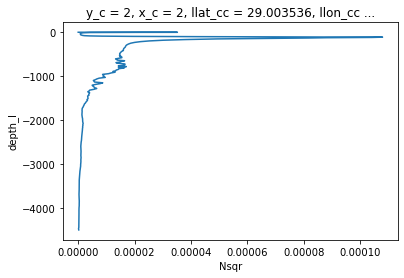

In [17]:
%%time
ds_moy["Nsqr"] = eosbn2(ds_moy.where(ds_moy.tmask), grid=grid).astype(np.float32, casting="same_kind")
ds_moy.Nsqr.isel(x_c=1, y_c=1).plot(y="depth_l")


In [18]:
ds_moy

<xarray.Dataset>
Dimensions:   (x_c: 121, y_c: 139, z_c: 300, z_l: 300)
Coordinates:
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
    depth_c   (z_c) float64 -0.4805 -1.559 -2.794 ... -5.975e+03 -6.025e+03
    llat_cc   (y_c, x_c) float32 28.99 28.99 28.99 28.99 ... 30.99 30.99 30.99
    llon_cc   (y_c, x_c) float32 -31.0 -30.98 -30.97 ... -29.03 -29.02 -29.0
    e1t       (y_c, x_c) float64 1.622e+03 1.622e+03 ... 1.59e+03 1.59e+03
    e2t       (y_c, x_c) float64 1.627e+03 1.627e+03 ... 1.598e+03 1.598e+03
    e3t       (z_c, y_c, x_c) float64 1.0 1.0 1.0 1.0 ... 50.92 50.92 50.92
    tmask     (z_c, y_c, x_c) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
    depth_l   (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    vosaline  (z_c, y_c, x_c) float32 36.91 36.9 36.9 36.9 ... 0.0 0.0 0.0 0.0
    votemper  (z_c, y_c, x_c) float32 21.47 21.47 21.47 21.47 ... 0.0 0.0 0.0
    Nsqr      (z_l, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>

In [19]:
%%time
ds_moy.to_netcdf(mean_file, mode="w")

CPU times: user 1.44 s, sys: 367 ms, total: 1.81 s
Wall time: 2.46 s


## local definition of routines
when developping

In [8]:
from xgcm import Grid
_grav = 9.81
_zmet = "e3w"
_temp = "votemper"
_salt = "vosaline"
_zdim = "Z"
_zcoord = "depth_l"

def eosbn2(ds, grid=None, z_reverse=True):
    """ eosbn2 (from CDFTOOLS function eosbn2 in eos.f90)
    if z_reverse: assume that depth is negative and z-grid oriented downwards while weights are positive
    """
    temp = _temp
    salt = _salt
    zdim = _zdim
    zmetric = _zmet
    grav = _grav
    zcoord = _zcoord
    
    if grid is None: # no xgcm grid passed: use one without metrics (assume mid-depth points = w points)
        grid = Grid(ds)
    
    z_sign = -1. if z_reverse else 1.
    
    zt = grid.interp(ds[temp], zdim, boundary="extend")
    zs = grid.interp(ds[salt], zdim, boundary="extend") - 35.0
    zh = z_sign * ds[zcoord] # take minus (i.e. positive depth)
    
    zalbet = ( ( ( - 0.255019e-07 * zt + 0.298357e-05 ) * zt     #   ! ratio alpha/beta
                                       - 0.203814e-03 ) * zt   
                                       + 0.170907e-01 ) * zt \
           + 0.665157e-01                                    \
           +     ( - 0.678662e-05 * zs                         
                   - 0.846960e-04 * zt + 0.378110e-02 ) * zs \
           +   ( ( - 0.302285e-13 * zh                         
                   - 0.251520e-11 * zs                         
                   + 0.512857e-12 * zt * zt           ) * zh   
                   - 0.164759e-06 * zs                         
                +(   0.791325e-08 * zt - 0.933746e-06 ) * zt   
                                       + 0.380374e-04 ) * zh

    zbeta  = ( ( -0.415613e-09 * zt + 0.555579e-07 ) * zt        #   ! beta
                                    - 0.301985e-05 ) * zt     \
           + 0.785567e-03                                     \
           + (     0.515032e-08 * zs                           
                 + 0.788212e-08 * zt - 0.356603e-06 ) * zs    \
           +(  (   0.121551e-17 * zh                           
                 - 0.602281e-15 * zs                           
                 - 0.175379e-14 * zt + 0.176621e-12 ) * zh     
                                     + 0.408195e-10   * zs     
             + ( - 0.213127e-11 * zt + 0.192867e-09 ) * zt     
                                     - 0.121555e-07 ) * zh
        
    if "_metrics" in dir(grid):
        try:
            eosbn2 = z_sign * grav * zbeta * ( zalbet * grid.derivative(ds[temp], zdim, boundary="extend") 
                             - grid.derivative(ds[salt], zdim, boundary="extend") )
        except:
            if zmetric not in ds:
                raise ValueError("no metric found in dataset")
            eosbn2 = z_sign * grav * zbeta * ( zalbet * grid.diff(ds[temp], zdim, boundary="extend") 
                             - grid.diff(ds[salt], zdim, boundary="extend") ) / ds[zmetric]
    else:
        eosbn2 = z_sign * grav * zbeta * ( zalbet * grid.diff(ds[temp], zdim, boundary="extend") 
                             - grid.diff(ds[salt], zdim, boundary="extend") ) / ds[zmetric]

    return eosbn2